# Parcial HPC #2: paralelismo en CPU

En este parcial, diseñará una rutina de preprocesamiento eficaz para el análisis de audio. Emplee la transformada de Fourier para la obtención de espectrogramas junto a las herramientas de paralelismo vistas en clase.

**Contexto:** La ornitología es la rama de la biología centrada en la investigación de las aves. Si bien, es una de las clases (conjunto de especies) más documentadas, su estudio puede ser bastante difícil, pues la observación y la identificación de los cantos de estos animales supone todo un reto para los especialistas, más aún cuando se realiza en vida libre. Para apoyar dicha labor, diseñaremos un método de extracción de características basado en audios grabados con diferentes cantos de diversas especies.

#NOTA: El archivo original del bird_songs data era muy pesado por lo que se optó por utilizar el siguiente [script](https://github.com/MateoPissarello/birds-data-filter/blob/main/script.py) para obtener solo 100 audios por especie

In [1]:
import numpy as np
import scipy.io.wavfile as wavfile
import scipy.fft as fft
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
def show_image(path:str) -> None:
  img = mpimg.imread(path)
  plt.imshow(img)
  plt.axis('off')
  plt.show()

# 0. Obtenga el conjunto de datos

Para esta labor obtendremos un conjunto parcial de la colección de cantos de aves "Xeno Canto", disponible en: https://www.kaggle.com/datasets/vinayshanbhag/bird-song-data-set. Descargue el conjunto de datos y explorelo.


* ¿Cuántas aves diferentes tiene?
* Reproduzca un canto de cada especie, ¿nota la diferencia?,¿qué diferencia el canto de cada especie?

**nota:** Responda a estas preguntas antes de realizar el parcial

## Existen 5 tipos de especies en los audios:

### 1. Chivirín de cola oscura (Bewick's Wren)



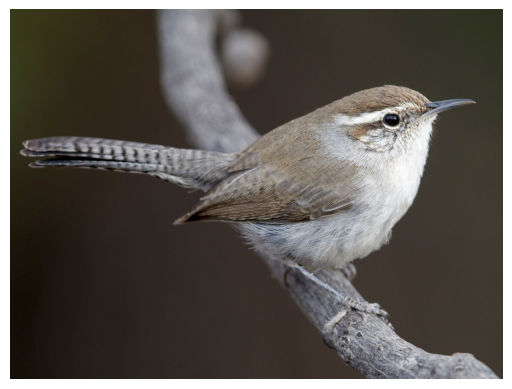

In [4]:
show_image("bird_images/chirivin.jpg")

### 2. Cardenal norteño (Northern Cardinal)

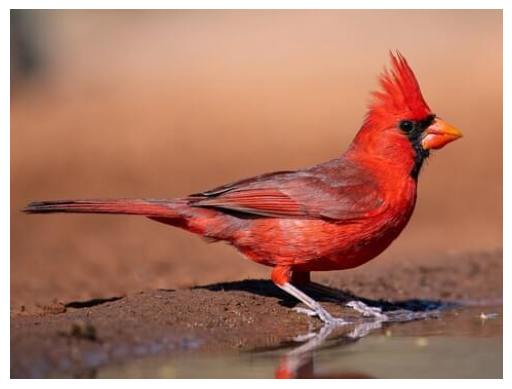

In [5]:
show_image("bird_images/cardenal.jpg")

### 3. Robín americano (American Robin)

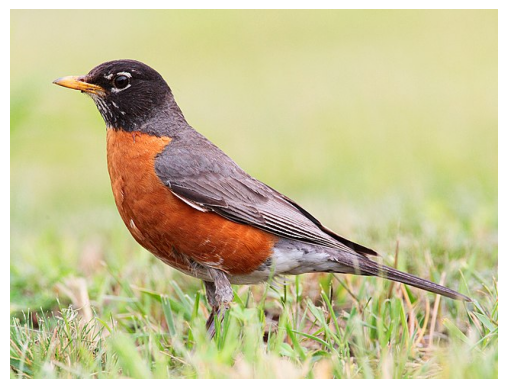

In [6]:
show_image("bird_images/robin.jpg")

### 4. Gorrión cantor (Song Sparrow)

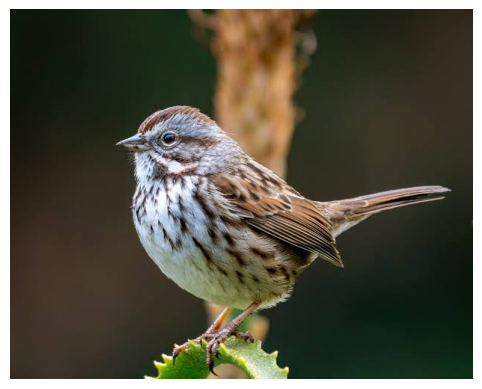

In [7]:
show_image("bird_images/gorrion diomedez.jpg")

### 5. Sinsonte norteño (Northern Mockingbird)

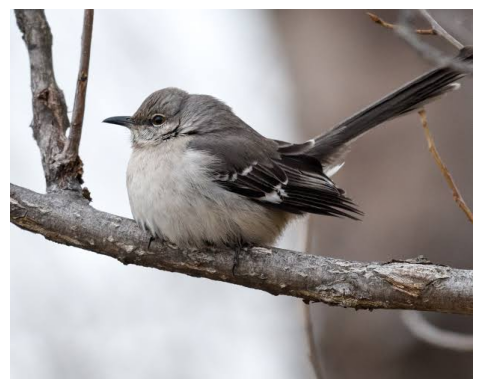

In [8]:
show_image("bird_images/gorrion_obeso.jpg")

## Las diferencias o características propias del canto de cada pajaro son las siguientes:


## 0.1 **bono:** La transformada de Fourier

Responda a las siguientes preguntas:
* ¿Qué es la transformada de Fourier?, ¿Para qué sirve?
* ¿Cómo cree que el uso de esta herramienta puede ayudar a resolver el problema propuesto?
* ¿Qué es un espectrograma?
* ¿Qué relación tiene el espectrograma con la transformada de Fourier?
* ¿Por qué considera que la extracción de un espectrograma necesita de paralelismo para ser optimizado?

**Contexto:** Si bien el contenido de la materia no contempla que ustedes aprendan el uso de diferentes herramientas empleadas para el preprocesamiento de datos, resulta vital para ustedes como científicos que comprendan el funcionamiento de estas para poder determinar una ruta de optimización.

**Nota:** Este bono solo será válido por 0.5 unidades en ESTE parcial y solo será tomado en cuenta si puede justificar su respuesta durante la sustentación.

¿Qué es la transformada de Fourier?, ¿Para qué sirve?

- Es una herramienta matemática que descompone una función en sus componentes de frecuencia, permitiendo analizar las frecuencias que componen una señal o función dada.
La transformada de Fourier se utiliza en una amplia variedad de campos, incluyendo la ingeniería, la física, las matemáticas aplicadas, la informática y la música, entre otros.

-

# 1. Espectrograma (implementación ingenua) [0.5]

Extraiga el espectrograma en ventanas de 50 ms de un audio (selecciónelo de forma aleatoria). Recuerde realizar la implementación utilizando numpy y/o scipy. Finalmente, mida el tiempo de su implementación y reportelo!!!.

**FAQ:**
* ¿Qué es un espectrograma?:  https://es.wikipedia.org/wiki/Espectrograma
* ¿Cómo calculo la transformada de Fourier? : https://docs.scipy.org/doc/scipy/tutorial/fft.html
* ¿La transformada de Fourier me dan números imaginarios?: https://es.khanacademy.org/math/precalculus/x9e81a4f98389efdf:complex/x9e81a4f98389efdf:complex-abs-angle/a/complex-number-absolute-value-and-angle-review


**Advertencia:** Este punto no será válido si utiliza algún método de procesamiento directo (función que realiza todo el proceso por ustedes).

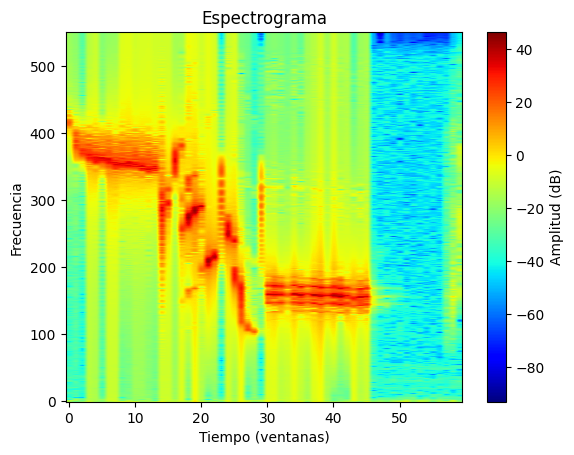

In [3]:
def generate_spectrogram(audio_path, window_size=0.050):
    rate, data = wavfile.read(audio_path)

    if len(data.shape) > 1:
        data = data.mean(axis=1)

    N = int(window_size * rate)
    total_samples = len(data)
    step = int(rate * window_size)  # Calcula el tamaño del paso basado en la duración de la ventana

    num_windows = (total_samples - N) // step + 1  # Calcula el número total de ventanas

    spectrograms = []

    for i in range(num_windows):
        window = data[i * step: i * step + N]
        fft_output = fft.fft(window)
        spectrogram = 20 * np.log10(np.abs(fft_output[:N//2]))
        spectrograms.append(spectrogram)

    spectrograms = np.array(spectrograms)

    return spectrograms


# Ejemplo de uso
audio_path = 'wavfiles_filtered/104637-14.wav'
spectrogram = generate_spectrogram(audio_path=audio_path)

# Visualización del espectrograma
plt.imshow(spectrogram.T, aspect='auto', origin='lower', cmap='jet')
plt.xlabel('Tiempo (ventanas)')
plt.ylabel('Frecuencia')
plt.title('Espectrograma')
plt.colorbar(label='Amplitud (dB)')
plt.show()


## Tiempo

In [5]:
%timeit generate_spectrogram(audio_path)

955 µs ± 10.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


# 2. Espectrograma (Implementación optimizada) [1]

Extraiga un espectrograma empleando múltiples hilos, compare la velocidad de ejecución.

**Tips:**
* Cada ventana puede considerarse un hilo.
* Sea cuidadoso al insertar los resultados, podrían haber condiciones de carrera.

**FAQ:**
* ¿Uso Mutex o uso Colas?: Cualquiera sirve, pero las Colas son más sencillas de usar.
*¿El orden importa en el espectrograma? : Si!!!!!!!
* ¿Me funciona, pero más lento?: Varíe el número de trabajos o revise si está ejecutando alguna tarea innecesariamente recurrente.
* ¿Cómo sé si me quedo bien? El espectrograma es una imagen, en cualquier caso utilice spectrum analyzer (https://academo.org/demos/spectrum-analyzer/) como referencia.

**Advertencia:** Este punto solo será válido si utiliza el mismo audio del punto anterior y acelera su ejecución.

In [42]:
def transform_window(window,N:int):
  fft_output = fft.fft(window) # Calcular la transformada de fourier en la ventana
  window = 20 * np.log10(np.abs(fft_output[:N//2]))  # Solo tomar la mitad del espectro
  window = np.array(window)
  return window

In [8]:
def obtain_windows(audio_path, window_size=0.050):
    rate, data = wavfile.read(audio_path) # el rate (tasa de muestreo) equivale a la frecuencia (Hz) que equivale a la cantidad de muestras de sonido que se toman por segundo

    # Convertir a mono si es necesario
    if len(data.shape) > 1:
        data = data.mean(axis=1) # Si es estereo lo vuelve a monkei

    # Configurar parámetros del espectrograma
    N = int(window_size * rate) # Calcula el punto de datos que van a haber por ventana
    total_samples = len(data)
    step = int(rate * window_size) # Calcula el tamaño del paso basado en la duración de la ventana

    # Calcular la cantidad de ventanas
    num_windows = (total_samples - N) // step + 1  # Calcula el número total de ventanas

    # Inicializar lista para almacenar los espectrogramas de cada ventana
    windows = []

    # Iterar sobre las ventanas y calcular el espectrograma para cada una
    for i in range(num_windows):
        window = data[i * step: i * step + N] #Obtenemos la ventana
        windows.append(window)

    return {
        "windows": windows,
        "N" : N
    }


# audio_path = 'wavfiles_filtered/104637-14.wav'
# windows = obtain_windows(audio_path)
# print(len(windows["windows"]))
# spectro = [transform_window(window,windows["N"]) for window in windows["windows"]]
# spectro = np.array(spectro)

# plt.imshow(spectro.T, aspect='auto', origin='lower', cmap='jet')
# plt.xlabel('Tiempo (ventanas)')
# plt.ylabel('Frecuencia')
# plt.title('Espectrograma')
# plt.colorbar(label='Amplitud (dB)')
# plt.show()








TypeError: Invalid shape (0,) for image data

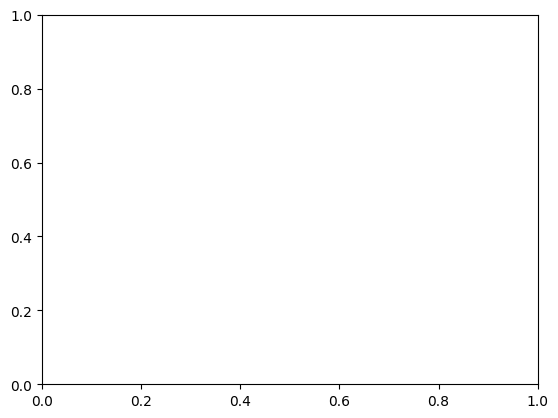

In [52]:
import concurrent.futures
import logging
import threading
import time
from queue import Queue
import random

def producer(pipeline, window, N):
    """
    The producer function takes a pipeline and a window as input parameters.
    It transforms the window using the transform_window function and sets the transformed window as a message in the pipeline with the label "Producer".
    
    Parameters:
    - pipeline: The pipeline object to which the transformed window will be set as a message.
    - window: The window to be transformed.
    """
    window = transform_window(window, N)
    pipeline.set_message(window, "Producer")
    # pipeline


def consumer(pipeline):
    """
    Consume messages from the pipeline and append them to the global spectrogram.
    
    Parameters:
        pipeline (Pipeline): The pipeline object to consume messages from.
    
    Returns:
        None
    """
    while True:
        if len(pipeline.spectrogram) < 60:
            #print("Len spectrogram: ", len(pipeline.spectrogram))
            pipeline.get_message("Consumer")
        if len(pipeline.spectrogram) == 60:
            pipeline.task_done()
            break
        else:
            time.sleep(0.001)  # Espera un corto tiempo antes de intentar consumir de nuevo

class Pipeline(Queue):
    """
    Class to allow a single element pipeline between producer and consumer.
    """
    def __init__(self):
        super().__init__(maxsize=60)
        self.lock = threading.Lock()
        self.spectrogram = []

    def get_message(self, name):
       #logging.debug("%s:about to get from queue", name)
       value = self.get()
       with self.lock():
        self.spectrogram.append(value)
       #logging.debug("%s:got %s from queue", name, type(value))
       return value  
       
    def set_message(self, value, name):
        #logging.debug("%s:about to add %s to queue", name, type(value))
        self.put(value)
        #logging.debug("%s:added %s to queue", name, type(value))


def calc_spectrogram_optimized(pipeline: Pipeline, audio_path: str) -> np.array :
    data = obtain_windows(audio_path)
    windows = data["windows"]
    N = data["N"]
    with concurrent.futures.ThreadPoolExecutor(max_workers=61) as executor:
        executor.submit(consumer, pipeline)
        for i in range(len(windows)):
            executor.submit(producer,pipeline,windows[i],N)
    return np.array(pipeline.spectrogram)

def run():
    #format = "%(asctime)s: %(message)s"
    #logging.basicConfig(format=format, level=logging.INFO,
    #                   datefmt="%H:%M:%S")
    #logging.getLogger().setLevel(logging.DEBUG)

    pipeline = Pipeline()

    audio_path = 'wavfiles_filtered/104637-14.wav'
    data = obtain_windows(audio_path)
    windows = data["windows"]
    N = data["N"]
    spectrogram = calc_spectrogram_optimized(pipeline=pipeline,audio_path=audio_path)
    plt.imshow(spectrogram.T, aspect='auto', origin='lower', cmap='jet')
    plt.xlabel('Tiempo (ventanas)')
    plt.ylabel('Frecuencia')
    plt.title('Espectrograma')
    plt.colorbar(label='Amplitud (dB)')
    plt.show()

run()

In [37]:
pipeline = Pipeline()

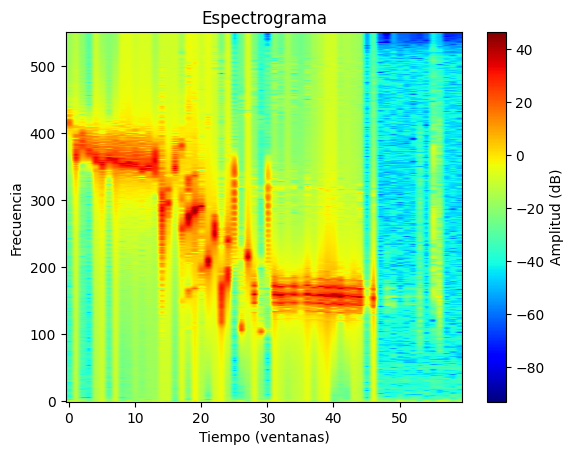

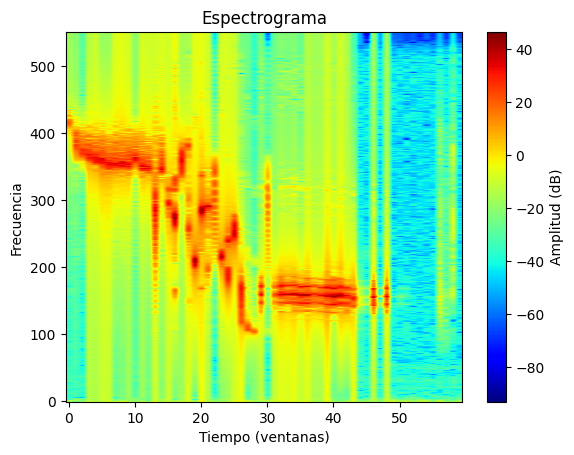

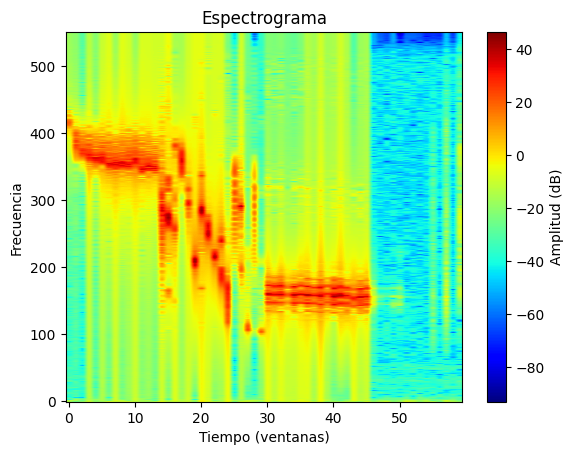

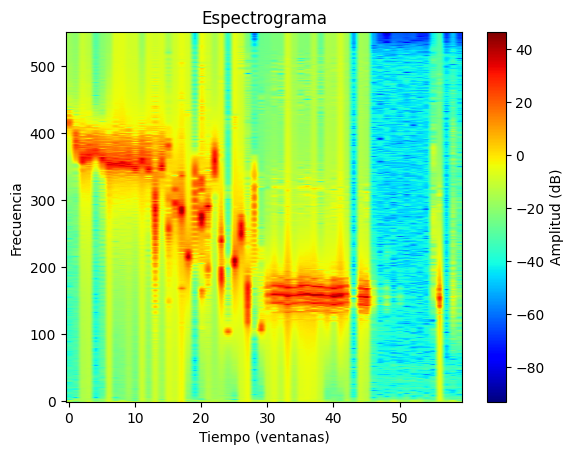

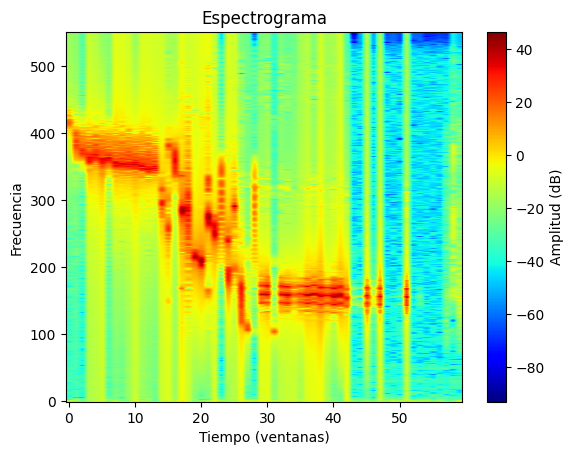

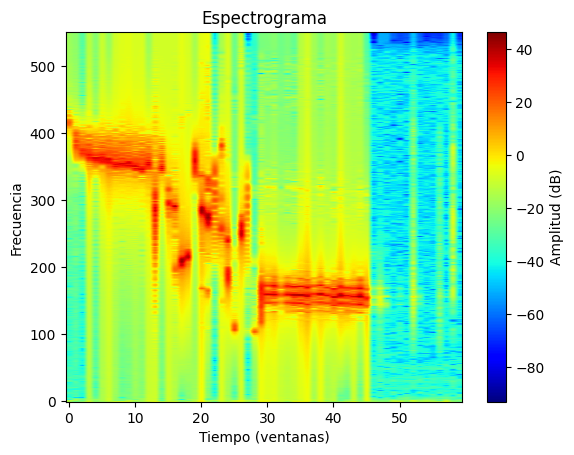

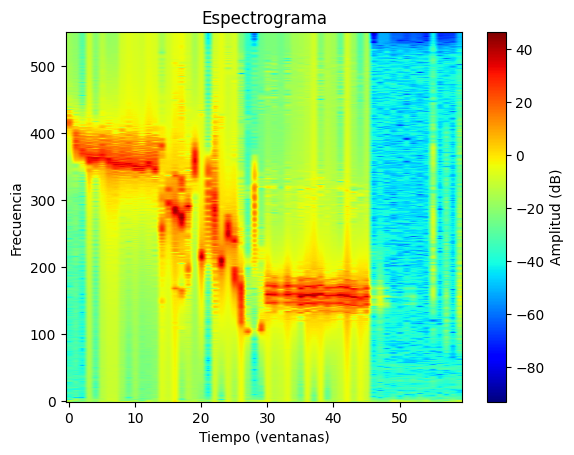

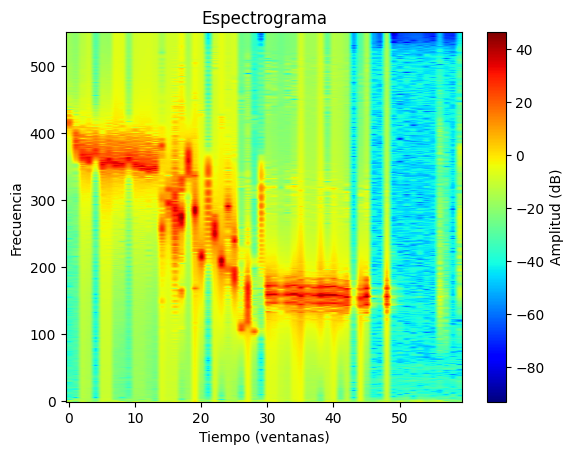

219 ms ± 7.09 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [41]:

%timeit -n 1 -r 1 calc_spectrogram_optimized(pipeline)

# 3. Extraiga múltiples espectrogramas. [1]

Empleando la función del punto anterior, utilice múltiples procesos para extraer el espectrograma de 100 audios por especie (puede seleccionarlos de forma aleatoria) y guardarlos (.png).

**Tips:**
Ejecute en local.

**Advertencia:** Debe reportar el tiempo de ejecución del proceso, las características del computador donde lo corrió y mostrar algunos ejemplos.